In [1]:
from stable_baselines3 import PPO

from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper, DiscreteActionWrapper
from citylearn.data import DataSet

from art.estimators.classification import PyTorchClassifier as classifier
from art.attacks.evasion import AutoConjugateGradient as ACG

from torch.nn import CrossEntropyLoss

from tqdm import tqdm

import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

todo: add test env (new seed?)

In [3]:
dataset_name = 'citylearn_challenge_2022_phase_2' #only action is electrical storage

In [4]:
schema = DataSet.get_schema(dataset_name)

In [16]:
schema['observations'].keys()

dict_keys(['month', 'day_type', 'hour', 'daylight_savings_status', 'outdoor_dry_bulb_temperature', 'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 'outdoor_relative_humidity', 'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 'diffuse_solar_irradiance', 'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 'direct_solar_irradiance', 'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h', 'carbon_intensity', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 'indoor_relative_humidity', 'non_shiftable_load', 'solar_generation', 'cooling_storage_soc', 'heating_storage_soc', 'dhw_storage_soc', 'electrical_storage_soc', 'net_electricity_consumption', 'electricity_pric

In [21]:
active_obs = []
for key in schema['observations'].keys():
    value = schema['observations'][key]['active']
    if value:
        active_obs.append(key)
for item in active_obs:
    print(item)

month
day_type
hour
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
non_shiftable_load
solar_generation
electrical_storage_soc
net_electricity_consumption
electricity_pricing
electricity_pricing_predicted_6h
electricity_pricing_predicted_12h
electricity_pricing_predicted_24h


In [18]:
schema['observations']['carbon_intensity']['active']

True

In [25]:
def make_discrete_env(schema, action_bins: int = 10, bldg: list = ['Building_1'], single_agent: bool = True, seed:int = 0):
    """Because ART's attacks are designed for supervised learning they one work with ANNs with a single label or head, using multiple buildings adds an action/head for each"""
    env = CityLearnEnv(schema, 
        central_agent=single_agent, 
        buildings=bldg, 
        random_seed=seed)
    #Because ART attacks are made for classification tasks we need a discrete action space 
    env = DiscreteActionWrapper(env, bin_sizes=[{'electrical_storage':action_bins}])
    #Calendar observations are periodically normalized, everything else is min/max normalized 
    env = NormalizedObservationWrapper(env)
    #provides an interface for SB3
    env = StableBaselines3Wrapper(env)
    return env

In [26]:
building = list(schema['buildings'].keys())[0] #the first building from the schema's building keys
bins = 10
env = make_discrete_env(schema=schema, 
                        bldg=[building], 
                        action_bins=bins)

In [27]:
env.buildings[0].electrical_storage.soc

[0.0]

In [28]:
type(env.observations)

list

In [29]:
help(env.buildings[0])

Help on Building in module citylearn.building object:

class Building(citylearn.base.Environment)
 |  Building(energy_simulation: citylearn.data.EnergySimulation, weather: citylearn.data.Weather, observation_metadata: Mapping[str, bool], action_metadata: Mapping[str, bool], carbon_intensity: citylearn.data.CarbonIntensity = None, pricing: citylearn.data.Pricing = None, dhw_storage: citylearn.energy_model.StorageTank = None, cooling_storage: citylearn.energy_model.StorageTank = None, heating_storage: citylearn.energy_model.StorageTank = None, electrical_storage: citylearn.energy_model.Battery = None, dhw_device: Union[citylearn.energy_model.HeatPump, citylearn.energy_model.ElectricHeater] = None, cooling_device: citylearn.energy_model.HeatPump = None, heating_device: Union[citylearn.energy_model.HeatPump, citylearn.energy_model.ElectricHeater] = None, pv: citylearn.energy_model.PV = None, name: str = None, maximum_temperature_delta: float = None, **kwargs: Any)
 |  
 |  Base class for b

A single environment can be dummy vector wrapped:

dvenv = DummyVecEnv([lambda: env])

The entire environment may not be picklable or compatible with SubProcVecEnv

Define vectorized training environment, seems that citylearn is not compatible: "TypeError: 'StableBaselines3Wrapper' object is not callable" is raised by 

num_cpu = cpu_count()

subproc_vec_env = DummyVecEnv([make_discrete_env(schema=schema, action_bins=20, seed=i) for i in range(num_cpu)])

Define RL agent

In [30]:
policy_kwargs = dict(net_arch=[256, 256])
agent = PPO('MlpPolicy', 
            env,
            device='cuda',
            policy_kwargs=policy_kwargs,
            tensorboard_log='logs/Phase1/PPO/',
            )

Train victim agent (Python: Launch Tensorboard)

In [31]:
episodes = 300
T = env.time_steps - 1
agent_name = f'default_PPO_{dataset_name}_{building}_{bins}_bins_{episodes}'

try:
    agent = agent.load(path=f"Models/Victim/{agent_name}", env=env)
    print('Model loaded from storage')
except:
    print("No saved agent found by that name")
    agent.learn(total_timesteps=int(T*episodes), tb_log_name=agent_name, progress_bar=True)
    agent.save(f"Models/Victim/{agent_name}")


Model loaded from storage


In [32]:
def format_kpis(env):
    """displays the KPIs from the evnironment's most recent timestep.
    This function can be called after an agent runs in a test env to evaluate performance"""

    kpis = env.evaluate().pivot(index='cost_function', columns='name', values='value')
    kpis = kpis.dropna(how='all')
    kpis = kpis['District']
    kpis = kpis[kpis != 0]
    return kpis

### are the observation and action traces stored in the env?

In [33]:
def eval_agent(env, agent):
    """displays the KPIs for each building and district
    ref quickstart"""
    obs_list = []

    observations = env.reset()

    while not env.done:
        obs_list.append(observations)
        actions, _ = agent.predict(observations, deterministic=True)
        observations, _, _, _ = env.step(actions)
    obs_list.append(observations)
    
    return format_kpis(env), np.array(obs_list)

Unperturbed agent performance

In [34]:
baseline_kpis, baseline_obs = eval_agent(env,agent)
display(baseline_kpis)

cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.889286
cost_total                               0.820249
daily_one_minus_load_factor_average      1.057196
daily_peak_average                       0.912028
electricity_consumption_total            0.894755
monthly_one_minus_load_factor_average    0.986110
ramping_average                          1.171399
zero_net_energy                          1.093327
Name: District, dtype: float64

We'll prepare an index with our feature names, since CityLearn does not name them properly

In [10]:
index = env.observation_names[0]
#add second index for periodic features
for i in [1,3,5]:
    index.insert(i, index[i-1] + '_cos')
#add suffix for other periodic features
for i in [0,2,4]:
    index[i] += '_sin'

In [37]:
df_baseline_obs = pd.DataFrame(baseline_obs, columns=index)

<Axes: >

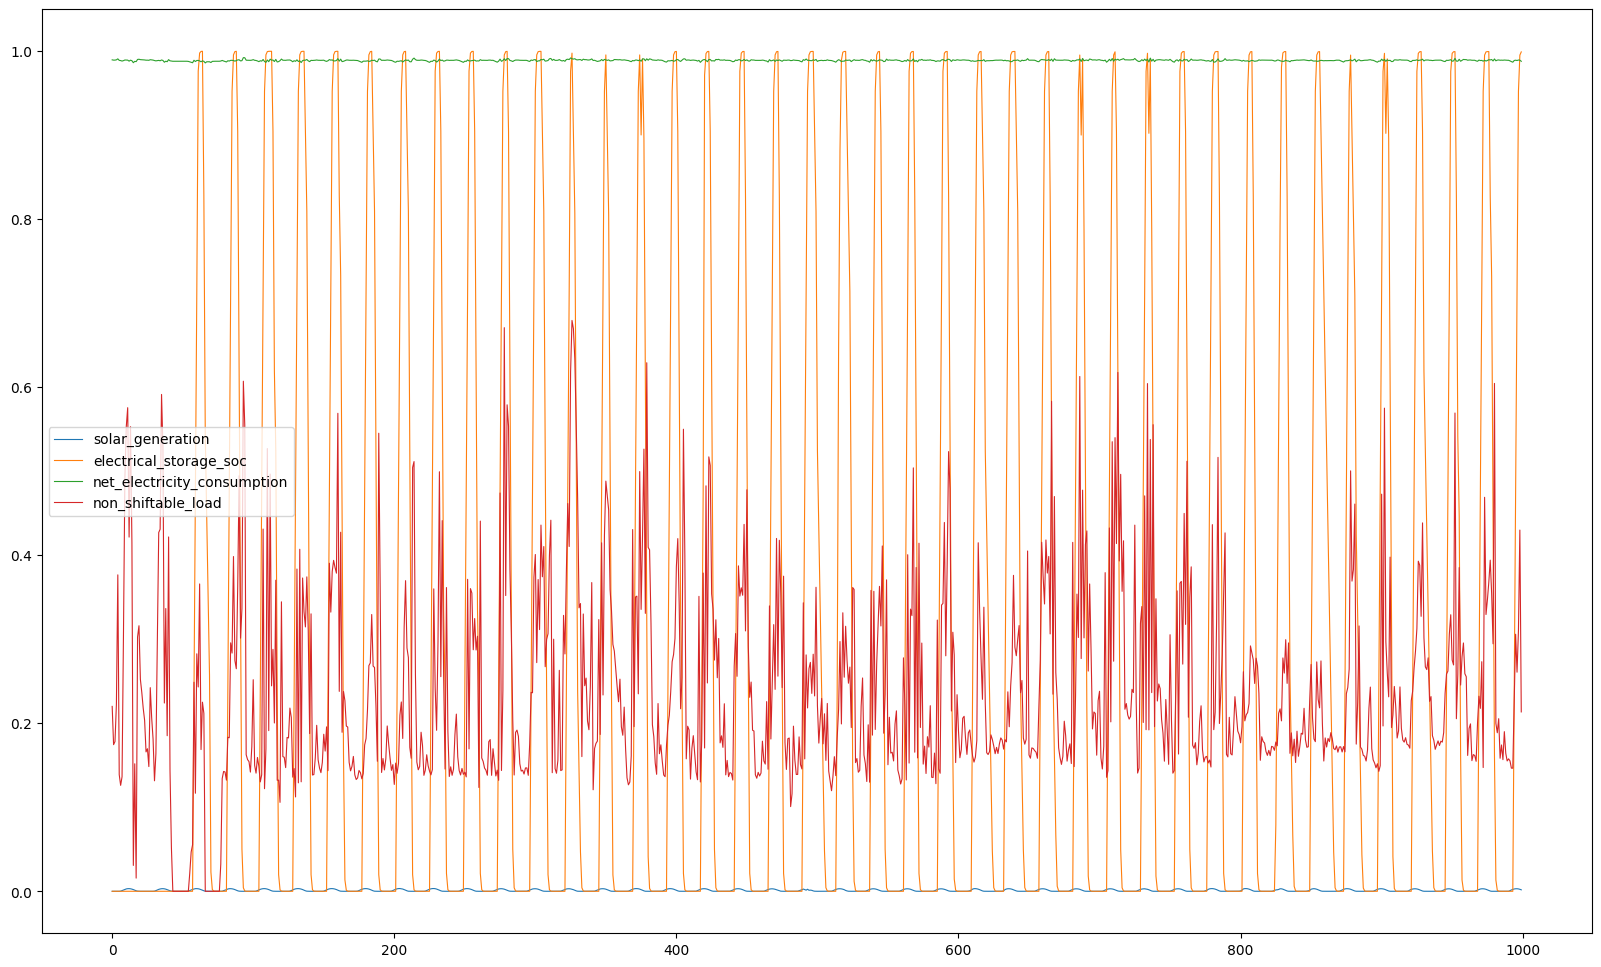

In [38]:
df_baseline_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:1000].plot.line(figsize=(20,12), lw=0.8)

In [39]:
def eval_rand_attack(agent, env, eps=0.3):
    """displays the KPIs for each building and district withc random noise in the observations
    ref quickstart"""
    obs_list = []
    asr = 0

    observations = env.reset()
    
    while not env.done:
        obs_list.append(observations)
        noisey_obs = observations + np.random.rand(*observations.shape)*eps
        a_adv, _ = agent.predict(noisey_obs, deterministic=True)
        actions, _ = agent.predict(observations, deterministic=True)
        if a_adv!=actions: #check if the perturbation changed the agent's action
            asr+=1
        observations, _, _, _ = env.step(a_adv)
    obs_list.append(observations)

    asr/=env.time_steps
    print(f'The Adversarial success rate is: {asr}')
    return format_kpis(env), np.array(obs_list)

Model performance while observations are perturbed by random noise [0,1). Note that all the observation values are normalized to [0,1]

In [40]:
rand_kpis, rand_obs = eval_rand_attack(agent, env, eps=0.3)

The Adversarial success rate is: 0.42534246575342466


Here's the regret for the random attack:

In [41]:
display(baseline_kpis - rand_kpis)

cost_function
annual_peak_average                     -3.504974e-13
carbon_emissions_total                  -3.561201e-02
cost_total                              -4.168179e-02
daily_one_minus_load_factor_average      4.193267e-06
daily_peak_average                      -4.941949e-02
electricity_consumption_total           -3.855277e-02
monthly_one_minus_load_factor_average   -1.186557e-04
ramping_average                         -1.017633e-01
zero_net_energy                          8.795851e-03
Name: District, dtype: float64

In [42]:
df_rand_obs = pd.DataFrame(rand_obs, columns=index)

<Axes: >

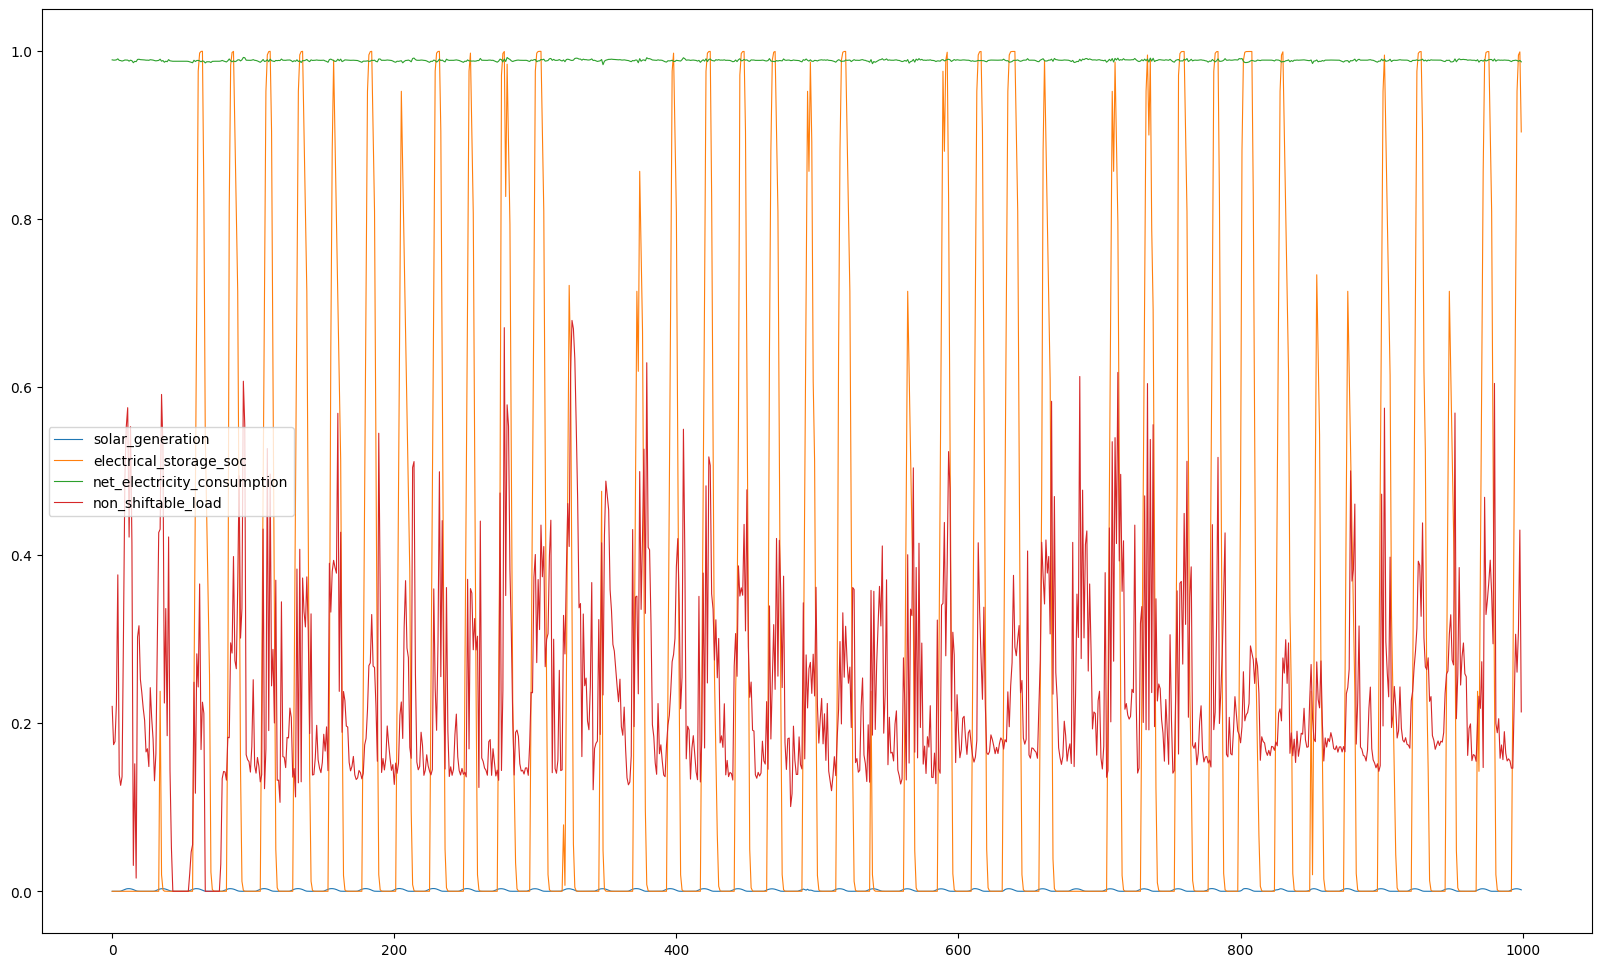

In [43]:
df_rand_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:1000].plot.line(figsize=(20,12), lw=0.8)

Define our gradient based attack:

In [11]:
def extract_actor(agent):
    """Extracts the policy network from and SB3 actor critic algorithm as a pytorch seuqential network"""
    from copy import deepcopy
    policy_net = deepcopy(agent.policy.mlp_extractor.policy_net) #copies shared net rather than referencing
    policy_net.add_module('actions', agent.policy.action_net)
    return policy_net

In [12]:
def define_attack(agent, env, ART_atk, loss_fn=CrossEntropyLoss(), **kwargs):
    """returns an ART attack function based on the input gym enviornment, SB3 Agent and ART attack class"""
    
    agent_policy = extract_actor(agent)

    victim_policy = classifier(
        model=agent_policy,
        loss=loss_fn, 
        nb_classes=env.action_space[0].n,
        input_shape=agent.observation_space.shape,
        device_type='gpu'
        )

    return ART_atk(estimator=victim_policy, verbose=False, **kwargs)

In [13]:
def eval_untargeted_attack(agent, env, atk, time_steps:int=None, mask:list=None):
    """Evaluates an SB3 agent subject to untargeted observation perturbations generated by an ART evasion attack"""
    obs_list = []
    asr = 0

    observations = env.reset()
    #failed_adv_exs = 0
    if time_steps is None:
        time_steps = env.time_steps - 1
    if mask is None:
        mask=np.ones(agent.observation_space.shape[0]) #1 for all features

    for _ in tqdm(range(time_steps)):

        obs_list.append(observations)

        adv_obs = np.expand_dims(observations, axis=0) #ART atks expect a 2d array
        #would using the true label/action imporve the asr? it would hurt adversarial training: https://arxiv.org/abs/1611.01236
        adv_obs = atk.generate(adv_obs, mask=mask)
        adv_obs = np.squeeze(adv_obs) #CityLearn envs expect a 1d array
        
        a_adv, _ = agent.predict(adv_obs, deterministic=True)
        #actions, _ = agent.predict(observations, deterministic=True)
        if not np.array_equal(adv_obs, observations): #check if an adversarial example was crafted
            asr+=1
        #if a_adv!=actions: #check if the perturbation changed the agent's action
        #    asr+=1
        #elif np.array_equal(adv_obs, observations): #when the victim's action is unchanged, check if an adv observation was crafted
        #    failed_adv_exs+=1
        observations, _, _, _ = env.step(a_adv)

        if env.done:
            break
    
    obs_list.append(observations)
    asr/=time_steps
    print(f'The Adversarial success rate is: {asr}')
    #print(f'{failed_adv_exs} adversarial examples were produced but failed to change the victim\'s action')
    return format_kpis(env), np.array(obs_list)

In [16]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.05, #default 0.3,
    eps_step=0.02, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = define_attack(agent, env, ACG, **ACG_parameters)

Before attacking the victim, we must understand what we are perturbing. So we need to see which observations/features are active in the environment (NB that periodically normalized calendar features are not properly named by the environment, so we will do it ourselves ref: https://github.com/intelligent-environments-lab/CityLearn/issues/74 ):

In [14]:
observation_masks = pd.Series(1, index=index).to_frame(name='all')

It seems that all these observations are variable (changes to constant values would indicate perturbations), however perturbations to the date and time would be obvious to an analyst. We will mask these features in our attack so they will not be perturbed.

In [15]:
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [19]:
observation_masks

,all,mask_time
month_sin,1,0
month_cos,1,0
day_type_sin,1,0
day_type_cos,1,0
hour_sin,1,0
hour_cos,1,0
outdoor_dry_bulb_temperature,1,1
outdoor_dry_bulb_temperature_predicted_6h,1,1
outdoor_dry_bulb_temperature_predicted_12h,1,1
outdoor_dry_bulb_temperature_predicted_24h,1,1


Plot for preliminary results:
- outdoor_dry_bulb_temperature
- solar_generation
- electrical_storage_soc
- net_electricity_consumption
- electricity_pricing
- calculate power from grid/aggregate load

In [20]:
Adv_untargered_kpis, adv_obs = eval_untargeted_attack(agent, env, attack, time_steps=1000, mask=observation_masks['mask_time'].to_numpy())
#display(baseline_kpis - Adv_untargered_kpis)

100%|██████████| 1000/1000 [49:53<00:00,  2.99s/it] 


The Adversarial success rate is: 1.0


NameError: name 'baseline_kpis' is not defined

The adversarial regret from the untargeted adversarial attack is:

In [44]:
display(baseline_kpis - Adv_untargered_kpis)

cost_function
annual_peak_average                      0.000042
carbon_emissions_total                  -0.076540
cost_total                              -0.063261
daily_one_minus_load_factor_average      0.101663
daily_peak_average                      -0.076365
electricity_consumption_total           -0.081201
monthly_one_minus_load_factor_average    0.009951
ramping_average                         -0.194474
zero_net_energy                          0.033675
Name: District, dtype: float64

In [22]:
df_adv_obs = pd.DataFrame(adv_obs, columns=index)

<Axes: >

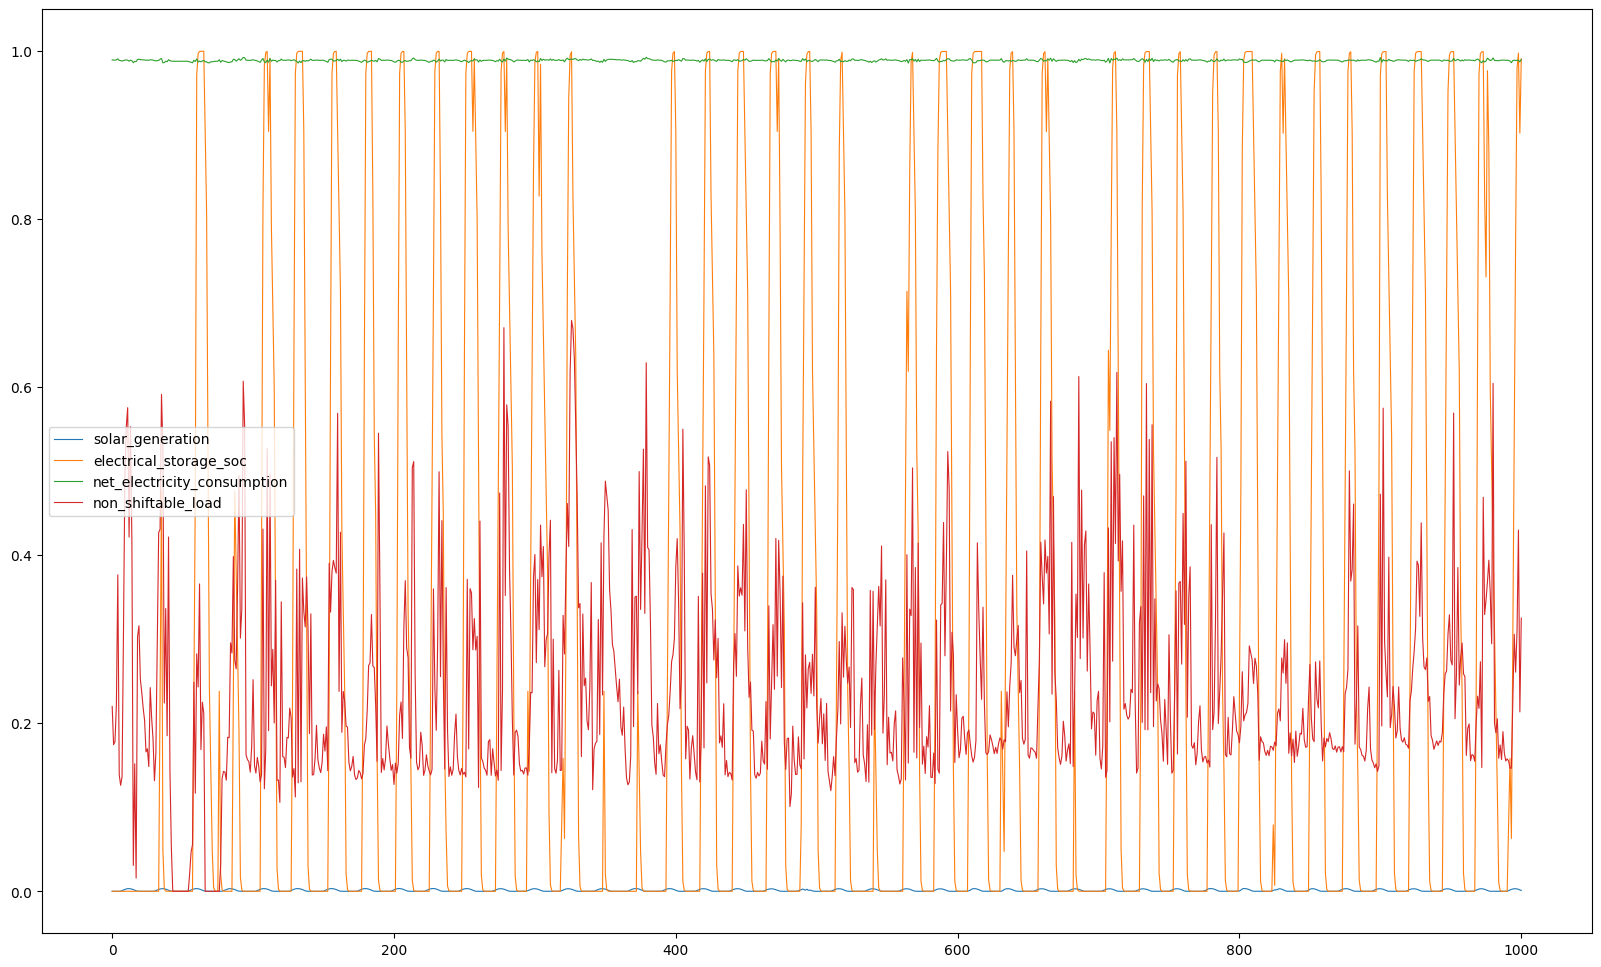

In [23]:
df_adv_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]].plot.line(figsize=(20,12), lw=0.8)

We could mask other features where tampering would be obvious e.g. temperture predictions vary between observations, but pricing predictions are identical for many obvservations and vary predictably.

In [16]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.025, #default 0.3,
    eps_step=0.02, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = define_attack(agent, env, ACG, **ACG_parameters)
Adv_untargered_kpis, adv_obs = eval_untargeted_attack(agent, env, attack, time_steps=1000, mask=observation_masks['mask_time'].to_numpy())

100%|██████████| 1000/1000 [19:27<00:00,  1.17s/it]

The Adversarial success rate is: 1.0


In [18]:
display(Adv_untargered_kpis)

cost_function
annual_peak_average                      0.888732
carbon_emissions_total                   0.940078
cost_total                               0.841876
daily_one_minus_load_factor_average      0.934474
daily_peak_average                       0.927198
electricity_consumption_total            0.952616
monthly_one_minus_load_factor_average    0.946387
ramping_average                          1.246153
zero_net_energy                          1.062136
Name: District, dtype: float64

In [19]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.0125, #default 0.3,
    eps_step=0.007, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = define_attack(agent, env, ACG, **ACG_parameters)
Adv_untargered_kpis, adv_obs = eval_untargeted_attack(agent, env, attack, time_steps=1000, mask=observation_masks['mask_time'].to_numpy())
display(Adv_untargered_kpis)

100%|██████████| 1000/1000 [35:39<00:00,  2.14s/it]

The Adversarial success rate is: 1.0


cost_function
annual_peak_average                      0.938485
carbon_emissions_total                   0.927714
cost_total                               0.819039
daily_one_minus_load_factor_average      0.878330
daily_peak_average                       0.848009
electricity_consumption_total            0.940192
monthly_one_minus_load_factor_average    0.944493
ramping_average                          1.162245
zero_net_energy                          1.062381
Name: District, dtype: float64

In [20]:
df_adv_obs = pd.DataFrame(adv_obs, columns=index)

<Axes: >

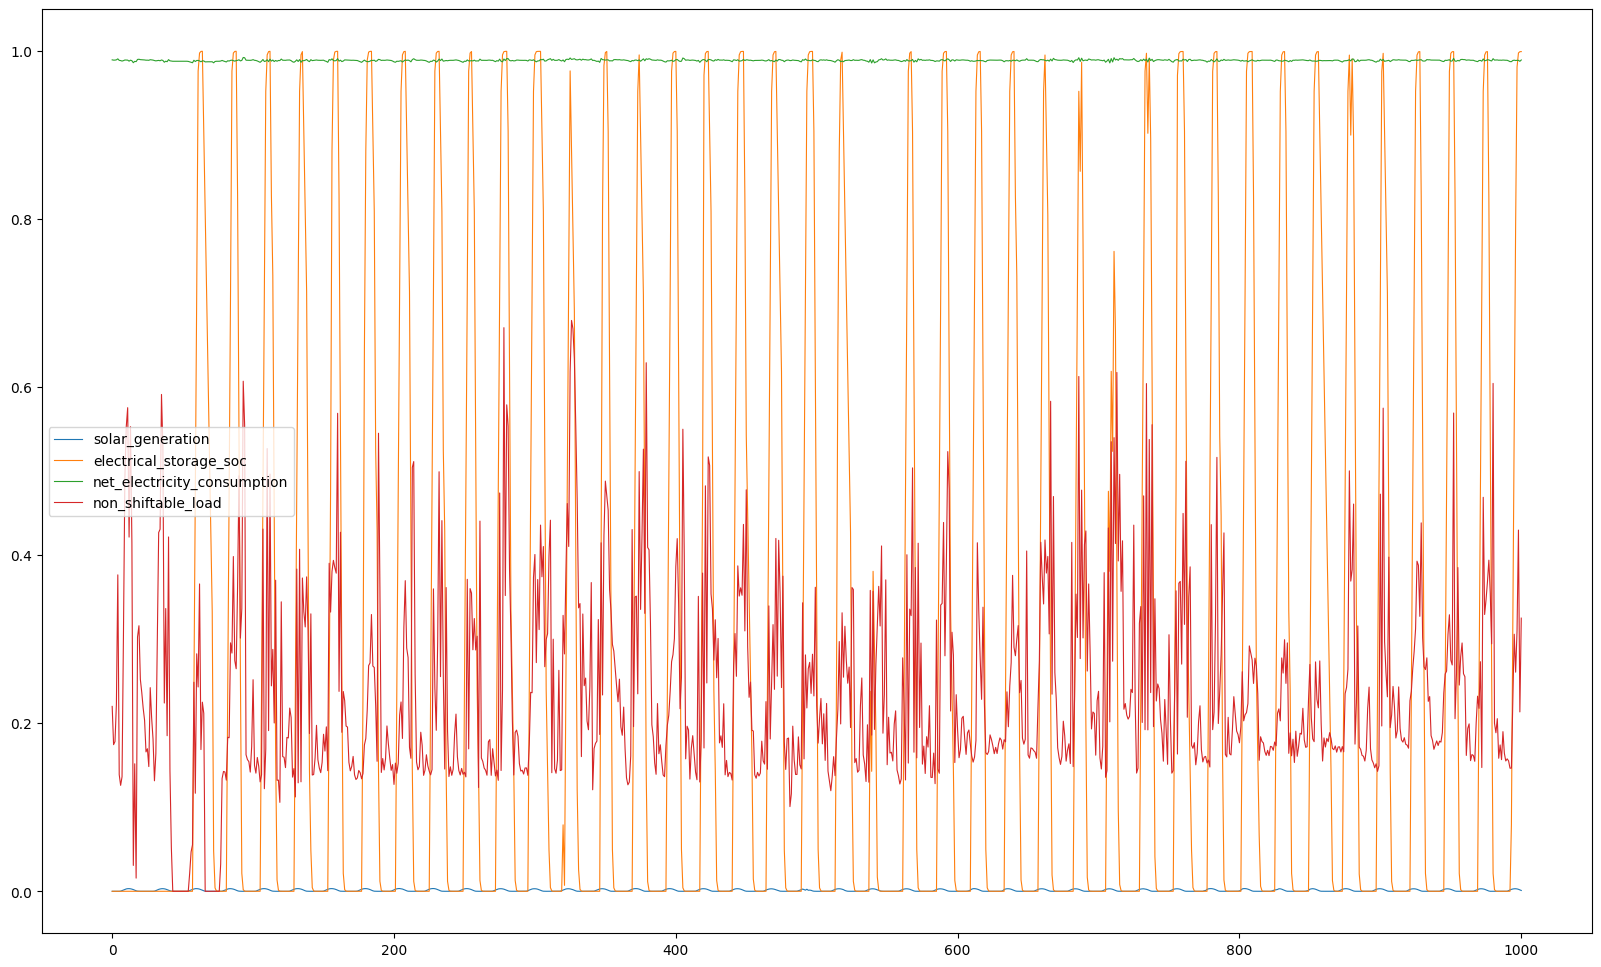

In [21]:
df_adv_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]].plot.line(figsize=(20,12), lw=0.8)

Evaluate agent with variable epsilon:
- Start at min value and increase in loop
- try multiple values in parallel
- return stat on the eps used, box plot?